In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
from joblib import dump, load
import matplotlib.pyplot as plt

In [ ]:
import string
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/'

In [ ]:

# # Load the Hotel_Reviews.csv file
# hotel_reviews_path = dataset_path+'Hotel_Reviews.csv'  # Replace with the actual path
# hotel_reviews_df = pd.read_csv(hotel_reviews_path)


# # Initialize an empty DataFrame to hold all game reviews
# DATA_GAME_REVIEWS_PATH = "data/game_reviews"
# N_HOTELS = 1068
# reviews_path = DATA_GAME_REVIEWS_PATH
# reviews = {}

# for h in range(1, N_HOTELS + 1):
#     hotel_df = pd.read_csv(os.path.join(dataset_path + reviews_path, f"{h}.csv"),
#                             header=None)
#     for review in hotel_df.iterrows():
#       reviews[review[1][0]] = {"hotel_name": review[1][1],"positive": review[1][2],
#                                       "negative": review[1][3],
#                                       "score": review[1][4]}


#     reviews[-1] = {"positive": "",
#                         "negative": "",
#                         "score": 8}

# game_reviews_df = pd.DataFrame.from_dict(reviews, orient='index')
# game_reviews_df = game_reviews_df.reset_index().rename(columns={'index': 'review_id'})

# hotel_positive_set = set(hotel_reviews_df['Positive_Review'].dropna())
# game_positive_set = set(game_reviews_df['positive'].dropna())

# hotel_negative_set = set(hotel_reviews_df['Negative_Review'].dropna())
# game_negative_set = set(game_reviews_df['negative'].dropna())

# # Check the intersection size between the specified columns
# positive_intersection_size = len(hotel_positive_set.intersection(game_positive_set))
# negative_intersection_size = len(hotel_negative_set.intersection(game_negative_set))

# print(f"The positive intersection size between the specified columns is: {positive_intersection_size}")
# print(f"The negative intersection size between the specified columns is: {negative_intersection_size}")

# The positive intersection size between the specified columns is: 0
# The negative intersection size between the specified columns is: 0

The positive intersection size between the specified columns is: 0
The negative intersection size between the specified columns is: 0


In [ ]:
reviews_df = pd.read_csv(dataset_path+'/Hotel_Reviews.csv')

In [ ]:
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]

In [ ]:
reviews_df = reviews_df.join(reviews_df.groupby('Hotel_Name')['Reviewer_Score'].mean(), on='Hotel_Name', rsuffix='_correct_mean')

In [ ]:
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score_correct_mean"].apply(lambda x: 1 if x < 8 else 0)

In [ ]:
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [ ]:
reviews_df = reviews_df.sample(frac = 0.15, replace = False, random_state=42)

In [ ]:
reviews_df.shape

(77361, 20)

In [ ]:
reviews_df["is_bad_review"].sum()

17206

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [ ]:


# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

In [ ]:
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
# add number of characters column
reviews_df["num_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["num_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [ ]:
reviews_df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,review,Reviewer_Score_correct_mean,is_bad_review,review_clean,neg,neu,pos,compound,num_chars,num_words
488440,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,Would have appreciated a shop in the hotel th...,7.790144,1,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113
274649,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,No tissue paper box was present at the room,8.942297,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10
374688,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,Pillows Nice welcoming and service,8.027273,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7
404352,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,Everything including the nice upgrade The Hot...,9.114286,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27
451596,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,Lovely hotel v welcoming staff,9.266413,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7


In [ ]:
# # create doc2vec vector columns
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# # train a Doc2Vec model with our text data
# model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# # transform each document into a vector data
# doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
# doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
# reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [ ]:
tfidf = TfidfVectorizer(min_df = 20)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
# tfidf = load('tfidf_vectorizer1.joblib')
# tfidf_result = tfidf.transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [ ]:
dump(tfidf, 'tfidf_vectorizer.joblib')
# dump(model, 'Doc2vec.joblib')

['tfidf_vectorizer.joblib']

In [ ]:
label = "is_bad_review"
ignore_cols = reviews_df.columns[:21]
features = [c for c in reviews_df.columns if c not in ignore_cols]

print(ignore_cols)


Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'review',
       'Reviewer_Score_correct_mean', 'is_bad_review', 'review_clean'],
      dtype='object')


In [ ]:
reviews_df.shape

(77361, 3281)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.66      0.74     11950
           1       0.34      0.60      0.43      3523

    accuracy                           0.64     15473
   macro avg       0.59      0.63      0.59     15473
weighted avg       0.73      0.64      0.67     15473

Confusion Matrix:
 [[7836 4114]
 [1421 2102]]
ROC-AUC Score: 0.6801421145205979


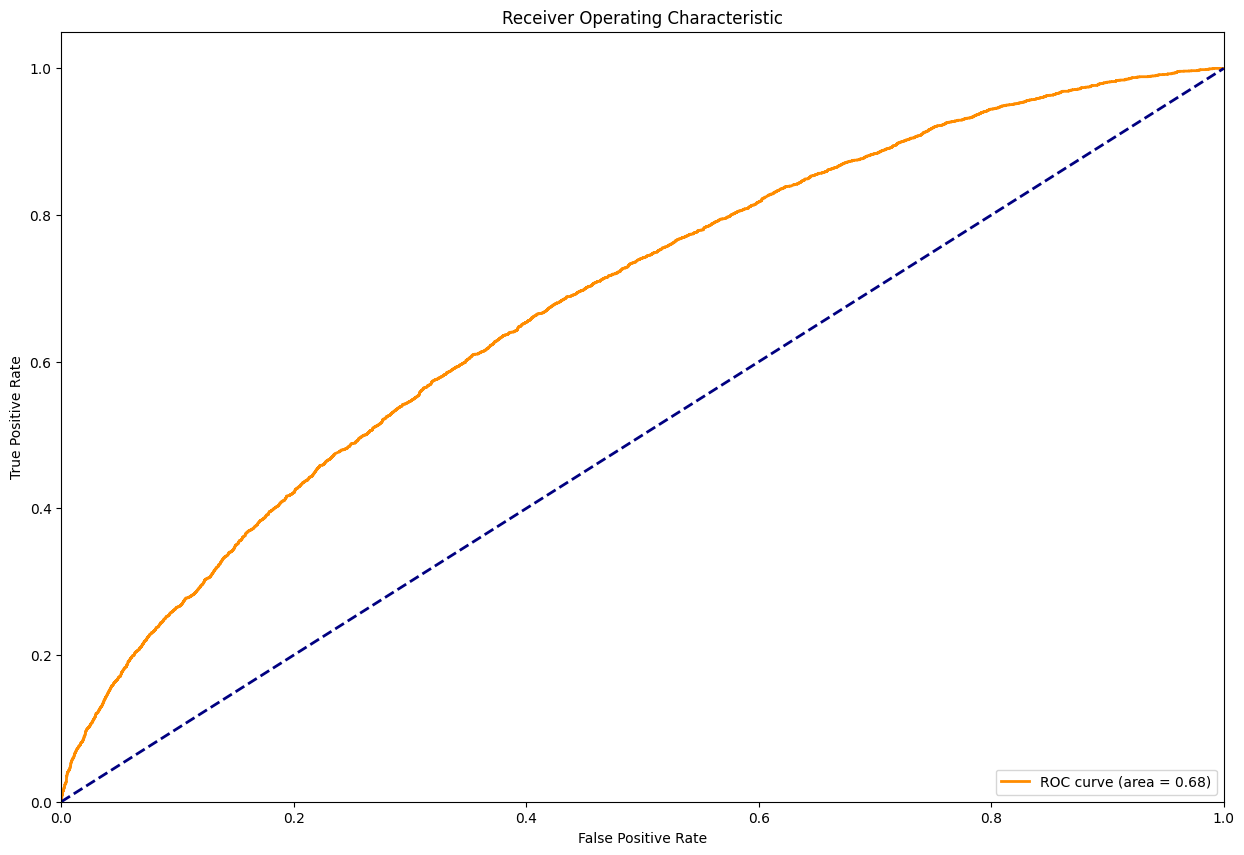

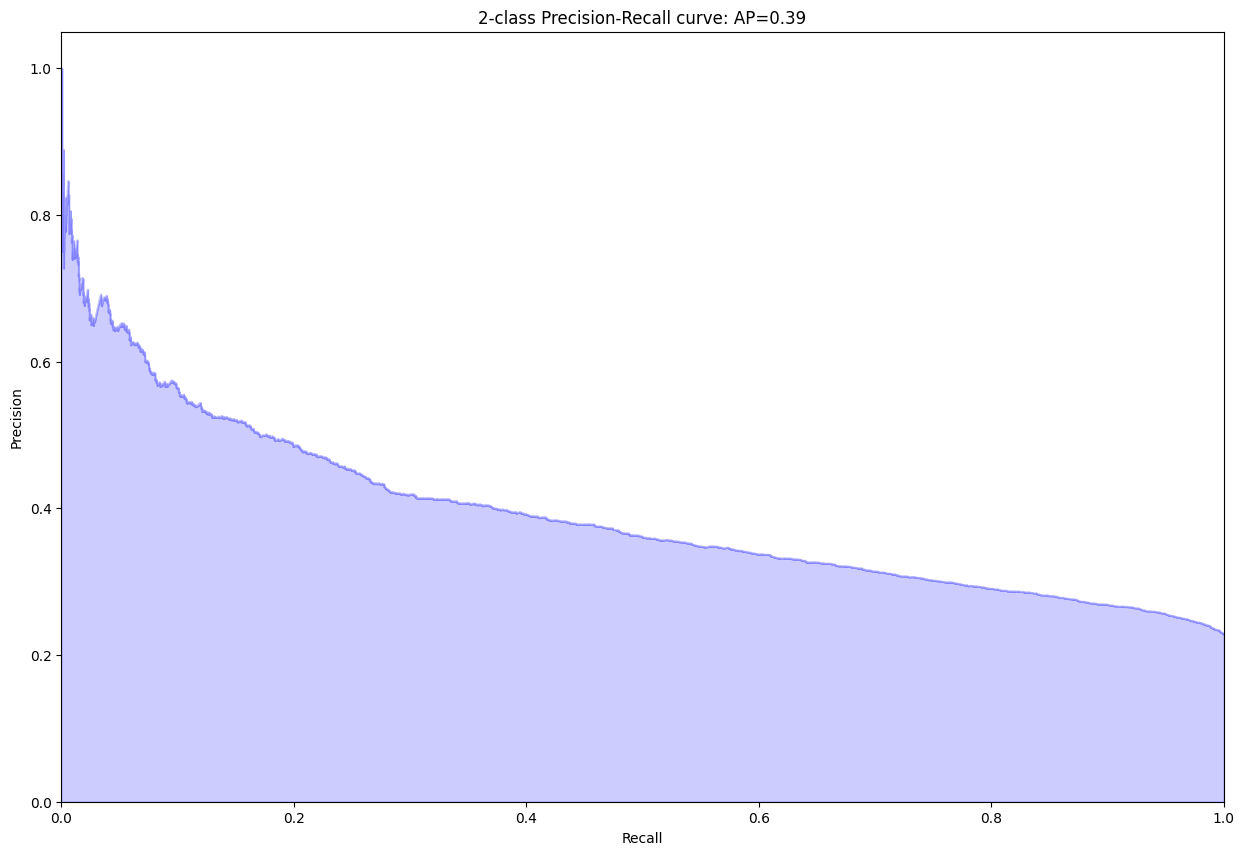

In [ ]:
# model = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight='balanced')
model = LogisticRegression(random_state=0, C=2, max_iter=1300, class_weight='balanced')
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, 'model.joblib')

# Predict on test set
y_pred1 = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize=(15, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [ ]:
pos_part,neg_part='good beautiful good good','Breakfast should be improved and lighting in the bedroom it is horrible, awful, disgusting'
pos = 0
neg = 0
score = 8.1
try:
    score = float(score)
except ValueError:
  pass

model = SentimentIntensityAnalyzer()

missing_values = ['N/A', 'NA', 'NULL', 'NaN', '_', 'MISSING', 'UNKNOWN', 'UNAVAILABLE']

if isinstance(pos_part,str) and pos_part.strip().lower() not in missing_values:
    clean_pos_part = clean_text(pos_part)
    # pos = model.polarity_scores(pos_part)
else:
    clean_pos_part=''

if isinstance(neg_part, str) and neg_part.strip().lower() not in missing_values:
    clean_neg_part = clean_text(neg_part)
    # neg = model.polarity_scores(neg_part)
else:
    clean_neg_part=''

# print(pos_part)
# print(neg_part)
# print(clean_pos_part)
# print(clean_neg_part)
review = pos_part + " " + neg_part
sentiment = model.polarity_scores(review)
cleaned_review = clean_text(review)
num_chars = len(review)
num_words = len(review.split(" "))
input = [sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound'], num_chars, num_words]
loaded_tfidf = load('tfidf_vectorizer.joblib')
input_tfidf = loaded_tfidf.transform([cleaned_review]).toarray().flatten()

input.extend(input_tfidf)

# Create DataFrame with the same feature names used during training
feature_names = ['neg', 'neu', 'pos', 'compound', 'num_chars', 'num_words'] + ["word_" + str(x) for x in loaded_tfidf.get_feature_names_out()]
input_df = pd.DataFrame([input], columns=feature_names)
# input = input + list(input_tfidf[0])



In [ ]:
loaded_model = load('model.joblib')

In [ ]:
prediction = loaded_model.predict(input_df)[0]
print(prediction)

1


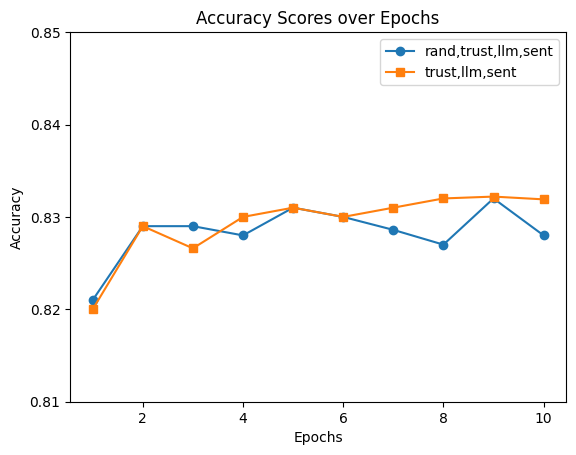

In [2]:
# import matplotlib.pyplot as plt


# epochs = list(range(1, 11))
# accuracy_scores_1 = [0.821, 0.829, 0.829, 0.828, 0.831, 0.83, 0.8286, 0.827, 0.832, 0.828] #rand,trust,llm,sent
# accuracy_scores_2 = [0.82, 0.829, 0.8266, 0.83, 0.831, 0.83, 0.831, 0.832, 0.8322, 0.8319]  #trust,llm,sent


# fig, ax = plt.subplots()
# ax.plot(epochs, accuracy_scores_1, label='rand,trust,llm,sent', marker='o')  # 'o' for circle markers
# ax.plot(epochs, accuracy_scores_2, label='trust,llm,sent', marker='s')  # 's' for square markers

# # Changing the y-axis scale to logarithmic
# ax.set_yticks([0.81, 0.82, 0.83, 0.84, 0.85])

# # Adding titles and labels
# ax.set_title('Accuracy Scores over Epochs')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Accuracy')
# ax.legend()

# # Show plot
# plt.show()
